# **Regression/Classification 실습 과제**

## 시작하기에 앞서 이번에는 저번 실습과는 달리 google colab에서 지원하는 gpu를 사용하여 과제를 진행해볼 예정이니 안내를 따라 gpu를 사용하는 것으로 바꾸고 과제 진행!
(1) 오른쪽 위 계정 밑에 있는 아래 방향 화살표 클릭  
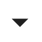  
(2) 런타임 유형 변경 클릭  
(3) T4 GPU 클릭  
(4) 화살표 옆 연결 클릭  
(5) 아래 코드 실행  
(6) 결과 값이 아래와 같이 나오는지 확인  
True  
1  
Tesla T4  

In [19]:
import torch
print(torch.cuda.is_available())   # True면 GPU 사용 가능
print(torch.cuda.device_count())   # GPU 개수
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

True
1
Tesla T4


## **1.1 Softmax Regression**
### 이번 과제에서는 Softmax Regression을 이용한 다차원 input, 다차원 output에 대한 classification 문제를 해결해볼 예정  
### <font color="red">**실습 시간에 배우지 않은 새로운 내용들은 설명과 함께 코드를 첨부했으니 이미 짜여져 있다고 그냥 지나치지말고 꼭!! 설명과 함께 참고를 해보길 바람**</font>
- 문제의 세팅은 사람의 손글씨 숫자를 판별하는 문제를 해결해보려고 함
- **현대의 이미지에 관련된 머신러닝 기법들 혹은 인공지능 모델들은 이 데이터에 대한 정확도를 높이는 연구에서부터 시작됐다고 봐도 무방**
- 데이터는 0부터 9까지의 정수로 구성이 되어 있고 이미지의 size는 28*28=784 차원의 이미지로 구성되어 있음
- 따라서 우리의 input은 784차원, output은 10차원인 multi-class classification 상황
<img src="https://storage.googleapis.com/tfds-data/visualization/fig/mnist-3.0.1.png" width="300">

### 1.1.1 학습 데이터 불러오기
- 이번 과제에서 사용해볼 데이터인 MNIST data는 기존에 구성되어 있는 데이터셋을 사용하기 때문에 실습 시간에 했던 것 처럼 데이터를 직접 구성을 하는 것이 아니라 pytorch package에서 dataset을 불러오는 방식 사용
- 여기에서 사용하는 package인 torchvision package는 pytorch에서 제공하는 영상, 이미지 데이터를 처리하기 용이한 tool들이 포함된 package
- 그 중에서 우리가 사용하는 것은 **torchvision.datasets**와 **torchvision.transforms**이고 이 둘은 각각 <font color='red'>**저장되어 있는 dataset**</font>을 불러올 수 있게 도와주는 package와 불러온 이미지 데이터를 우리가 <font color='red'>**쉽게 처리할 수 있는 형태**</font>로 바꿔주는 tool이 들어 있는 package
- 여기서는 이미지 데이터를 pytorch에서 처리할 수 있는 <font color='blue'>**Tensor dataset**</font>으로 바꿔주는데 사용


In [20]:
import torchvision.datasets as dsets
import torchvision.transforms as transforms

# MNIST dataset을 불러오고 Tensor dataset으로 바꿔주는 과정
mnist_train = dsets.MNIST(root='MNIST_data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)

### 1.1.2 Parameter 초기화 및 learning rate 설정 <font color="red"> (문제 1: 10점)</font>  
###<font color="red">**주석처리된 부분을 채워 넣으시오**</font>
- Linear regression, 1D logistic regression과 같은 방식으로 parameter 와 learning rate 설정
- 이번 과제의 경우 input이 784차원, output이 10차원인 경우이기 때문에 w=784*10 짜리 행렬이 되어야 하고 b = 10차원짜리 vector가 되어야 함.
- learning rate는 0.1로 설정해 볼 것
- 제공되는 부분 중 device='cuda' 부분은 gpu를 사용한 학습을 하기 위해 추가된 부분!!

In [21]:
w = torch.nn.Parameter(torch.randn(784, 10, device='cuda'), requires_grad=True)
b = torch.nn.Parameter(torch.randn(10, device='cuda'), requires_grad=True)

learning_rate = 0.1

### 1.1.3 Dataloader에 data 넣기
 - 지난 실습 시간에 이용했던 간단한 데이터가 아닌 multi-class classification과 같은 데이터의 양이 많은 경우에 대해서는 DataLoader를 사용해서 데이터들을 불러와야 함.
 - 이번에 우리가 사용하는 MNIST dataset도 학습데이터만 60000 장의 image와 테스트 데이터 10000장의 데이터를 포함하고 있음.
 - DataLoader는 torch.utils.data에서 호출을 오면 됨
 - DataLoader는 <font color="red">batch size</font>와 <font color="blue">shuffle</font>을 제공하는데 이 batch size는 모델 학습을 할때 한 번에 60000 장의 데이터를 보는 것이 어려우니 매번 gradient descent를 할때마다 <font color="red">batch size만큼의 데이터</font>만 볼 수 있게 해주는 파트이고 shuffle은 데이터를 줄때 데이터들을 계속 같은 방식으로 주는게 아닌 <font color="red">섞어서</font> 줄 수 있게 하는 파트

In [22]:
from torch.utils.data import DataLoader

data_loader = DataLoader(dataset=mnist_train, batch_size=100, shuffle=True)

### 1.1.4 Optimizer 선언 <font color="red">(문제 2: 10점)</font>.
###<font color="red">**주석처리된 부분을 채워 넣으시오**</font>
이번 실습에서는 optimizer로써 SGD optimizer 사용 해보기
실습 자료에서 SGD optimizer를 사용하던 방식과 똑같이 정의하면 됨


In [23]:
optimizer = torch.optim.SGD([w, b], lr=learning_rate) # optimizer 정의

### 1.1.5 Cost function과 Hypothesis 구성하여 학습 시켜보기 <font color="red">(문제 3: 20점)</font>.
###<font color="red">**주석처리된 부분을 채워 넣으시오**</font>
- **torch.nn.Softmax** 함수는 multi-class classification에 필요한 softmax 계산을 실행해줌
- torch.nn.Softmax는 torch.nn.Softmax(x, dim=i)의 형태로 이용하며 dim=i라고 넣어준 i 차원에 대해서 softmax 함수 값을 계산
- 우리의 경우에는 softmax 값을 계산해야하는 차원이 <font color='red'>**크기가 10인 마지막 차원**</font>에서 이루어져함을 기억할 것!!!  
\begin{align}\text{Softmax}(XW +b)\end{align}
- cost function은 수업시간에 배운 (generalized) cross entropy loss 사용
\begin{align}\text{Cost}(H)=-\frac{1}{N}\sum_{i=1}^N\sum_{j=1}^{10}(y_{ij}\log H_{ij})\end{align}
(주의!!) 수식에서 나와 있듯이 batch dimension에 대해서는 평균을 output dimension에 대해서는 합을 해야함

In [24]:
for epoch in range(100):
  avg_cost = 0 # 한 epoch당 평균 loss측정
  total_batch = len(data_loader) # 한 epoch안에서 몇 번의 iteration이 돌지 결정
  for X, Y in data_loader: # data loader에서 [batch_size, 28, 28, 1] 짜리 input과 [batch_size, 1] 짜리 output을 줌
    X = X.view(-1,784).cuda() # input data를 [batch_size, 784]로 변환
    Y = torch.nn.functional.one_hot(Y, num_classes=10).cuda() # output data를 [batch_size, 10]으로 변환
    # hypothesis = torch.nn.Softmax(dim=-1)(???) # 마지막 차원에 대해서 softmax!!
    # cost = ??? # 마지막 차원에 대해서는 sum, 데이터 개수 차원에 대해서는 평균 !!
    hypothesis = torch.nn.Softmax(dim=-1)(torch.mm(X, w) + b)  # 마지막 차원 softmax
    cost = -torch.mean(torch.sum(Y.float() * torch.log(hypothesis + 1e-9), dim=1))  # class 차원 sum, 배치 평균
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    avg_cost += cost / total_batch
  print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))

print('Learning finished')

Epoch: 0001 cost = 3.393854141
Epoch: 0002 cost = 1.033055544
Epoch: 0003 cost = 0.834809363
Epoch: 0004 cost = 0.735877335
Epoch: 0005 cost = 0.672968030
Epoch: 0006 cost = 0.627792120
Epoch: 0007 cost = 0.593144894
Epoch: 0008 cost = 0.565056384
Epoch: 0009 cost = 0.542549729
Epoch: 0010 cost = 0.523433685
Epoch: 0011 cost = 0.506836355
Epoch: 0012 cost = 0.491973013
Epoch: 0013 cost = 0.479217023
Epoch: 0014 cost = 0.467873454
Epoch: 0015 cost = 0.457249224
Epoch: 0016 cost = 0.447245955
Epoch: 0017 cost = 0.438535362
Epoch: 0018 cost = 0.431238085
Epoch: 0019 cost = 0.423205346
Epoch: 0020 cost = 0.416774571
Epoch: 0021 cost = 0.410014421
Epoch: 0022 cost = 0.404363632
Epoch: 0023 cost = 0.398606390
Epoch: 0024 cost = 0.392999440
Epoch: 0025 cost = 0.388791442
Epoch: 0026 cost = 0.383931458
Epoch: 0027 cost = 0.379548639
Epoch: 0028 cost = 0.375769049
Epoch: 0029 cost = 0.371645987
Epoch: 0030 cost = 0.367738634
Epoch: 0031 cost = 0.364605635
Epoch: 0032 cost = 0.361045897
Epoch: 0

### 1.1.6 테스트 데이터 불러오기
- 학습데이터와 마찬가지로 테스트 데이터도 불러와서 똑같이 DataLoader에 넣어주기

In [25]:
mnist_test = dsets.MNIST(root='MNIST_data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

test_loader = DataLoader(dataset=mnist_test,
                         batch_size=100,
                         shuffle=False)

### 1.1.7 테스트 데이터에 대해 정확도 측정해보기 <font color="red">(문제 4: 10점)</font>.
###<font color="red">**주석처리된 부분을 채워 넣으시오**</font>
- 실습 시간에 배웠던 테스트 데이터에 대한 예측을 먼저 진행
- 예측된 결과와 실제 정답을 비교하여 정확도 측정

In [26]:
with torch.no_grad():
  total_acc = 0
  total_batch = len(test_loader)
  for X_test, Y_test in test_loader:
    X_test = X_test.view(-1,784).cuda()
    Y_prediction = torch.nn.Softmax(dim=-1)(torch.mm(X_test, w) + b)

    Y_test = torch.nn.functional.one_hot(Y_test, num_classes=10).cuda()
    correct_prediction = torch.argmax(Y_prediction, dim=-1) == torch.argmax(Y_test, dim=-1)
    acc = torch.mean(correct_prediction.float())
    total_acc += acc / total_batch
  print('Accuracy:', total_acc.item())


Accuracy: 0.9186998605728149


### 1.1.8 무작위 테스트 데이터를 뽑아 예측해보기
- 실제로 우리 모델이 어떤 이미지를 어떻게 예측했는지 보기
- 아래의 cell을 반복 실행하다보면 실제 정답과 예측이 다른 경우가 나오고 어떤 데이터를 어떻게 오해를 했는지 확인할 수 있음

Label:  5
Prediction:  8


/usr/local/lib/python3.12/dist-packages/torchvision/datasets/mnist.py:81: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.12/dist-packages/torchvision/datasets/mnist.py:71: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


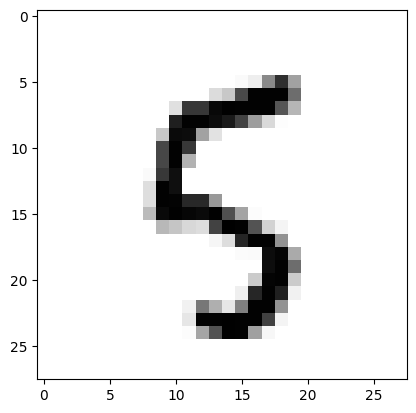

In [27]:
import matplotlib.pyplot as plt
import random

r = random.randint(0, len(mnist_test) - 1)
X_single_data = mnist_test.test_data[r:r + 1].view(-1, 28 * 28).float().to('cuda')
Y_single_data = mnist_test.test_labels[r:r + 1].to('cuda')

print('Label: ', Y_single_data.item())
single_prediction = torch.nn.Softmax(dim=-1)(torch.mm(X_single_data,w)+b)
print('Prediction: ', torch.argmax(single_prediction, 1).item())

plt.imshow(mnist_test.test_data[r:r + 1].view(28, 28), cmap='Greys', interpolation='nearest')
plt.show()